In [1]:
import paddle
import paddle.nn as nn
import paddle.optimizer as optim
import numpy as np
import os
from PIL import Image
from paddle.io import Dataset, DataLoader
from numpy.core.defchararray import decode, mod
import paddle
import numpy as np
import paddle.fluid as fluid
from paddle.fluid.dygraph import to_variable
from paddle.fluid.dygraph import Layer
from paddle.fluid.dygraph import Conv2D
from paddle.fluid.dygraph import BatchNorm
from paddle.fluid.dygraph import Pool2D
from paddle.fluid.dygraph import Conv2DTranspose
from visualdl import LogWriter
from datetime import datetime

PLEASE USE OMP_NUM_THREADS WISELY.


In [2]:
import paddle.nn as nn

class FCN(nn.Layer):
    def __init__(self, num_classes=1):
        super(FCN, self).__init__()
        
        # 基础特征提取网络，这里简化地使用VGG16的前几层作为示例
        self.features = nn.Sequential(
            nn.Conv2D(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2D(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2),
            
            nn.Conv2D(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2D(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2),
        )
        
        # 分割头
        self.classifier = nn.Sequential(
            nn.Conv2D(128, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return nn.functional.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)


In [3]:
# 1. 数据加载
class EyeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_size=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_size = transform_size
        self.image_list = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, os.path.splitext(self.image_list[idx])[0] + '.bmp')
        
        # 使用resize方法调整图像和掩码的尺寸
        image = Image.open(image_path).convert('RGB').resize(self.transform_size)
        mask = Image.open(mask_path).convert('L').resize(self.transform_size)
        
        image = paddle.to_tensor(np.array(image).astype('float32').transpose((2, 0, 1)) / 255.0)
        mask = paddle.to_tensor(np.array(mask).astype('float32')[np.newaxis, :, :] / 255.0)
        
        return image, mask
    
    def __len__(self):
        return len(self.image_list)

data_dir = "data/Train"
fundus_image_dir = os.path.join(data_dir, "fundus_image")
completed_masks_dir = os.path.join(data_dir, "Lesion_Masks", "Completed_Masks", "Atrophy")  # 使用Atrophy作为示例

train_dataset = EyeDataset(fundus_image_dir, completed_masks_dir, transform_size=(512,512))
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [4]:
import time  # 导入time模块

epochs = 50

# 创建一个LogWriter对象
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
log_dir = f"FCN_vdl_logs/{current_time}_epochs_{epochs}"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = LogWriter(log_dir)

# 3. 模型训练
model = FCN(num_classes=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(parameters=model.parameters(), learning_rate=0.001)


for epoch in range(epochs):
    total_loss = 0.0
    start_time = time.time()  # 记录epoch开始时间
    
    for batch_idx, (images, masks) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        
        total_loss += loss.numpy()[0]
        print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.numpy()[0]}")
    
    # 记录平均loss到VisualDL
    avg_loss = total_loss / len(train_loader)
    writer.add_scalar(tag="train/avg_loss", step=epoch, value=avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}")

    # 每个epoch结束后保存模型
    model_path = os.path.join("FCN_models", f"FCN_epoch{epoch+1}.pdparams")
    paddle.save(model.state_dict(), model_path)
    print(f"Saved model parameters to {model_path}")

    end_time = time.time()  # 记录epoch结束时间
    elapsed_time = end_time - start_time  # 计算epoch的训练时间
    print(f"Epoch {epoch+1} training time: {elapsed_time:.2f} seconds")

print("Training completed!")


W0813 14:46:16.231634   812 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 8.6, Driver API Version: 12.0, Runtime API Version: 11.2
W0813 14:46:16.235545   812 device_context.cc:465] device: 0, cuDNN Version: 8.1.


Epoch 1/50, Batch 1/100, Loss: 0.6972641944885254
Epoch 1/50, Batch 2/100, Loss: 0.640304446220398
Epoch 1/50, Batch 3/100, Loss: 0.5162877440452576
Epoch 1/50, Batch 4/100, Loss: 0.3437727987766266
Epoch 1/50, Batch 5/100, Loss: 0.45182985067367554
Epoch 1/50, Batch 6/100, Loss: 0.48747414350509644
Epoch 1/50, Batch 7/100, Loss: 0.5922821760177612
Epoch 1/50, Batch 8/100, Loss: 0.4565608501434326
Epoch 1/50, Batch 9/100, Loss: 0.44956302642822266
Epoch 1/50, Batch 10/100, Loss: 0.38592323660850525
Epoch 1/50, Batch 11/100, Loss: 0.46263521909713745
Epoch 1/50, Batch 12/100, Loss: 0.3065298795700073
Epoch 1/50, Batch 13/100, Loss: 0.24199403822422028
Epoch 1/50, Batch 14/100, Loss: 0.3981825113296509
Epoch 1/50, Batch 15/100, Loss: 0.3033033311367035
Epoch 1/50, Batch 16/100, Loss: 0.23130947351455688
Epoch 1/50, Batch 17/100, Loss: 0.24126487970352173
Epoch 1/50, Batch 18/100, Loss: 0.241043359041214
Epoch 1/50, Batch 19/100, Loss: 0.3429095447063446
Epoch 1/50, Batch 20/100, Loss: 0.

In [ ]:
# 1. 初始化模型
model = FCN(num_classes=1)

# 2. 加载模型参数
start_epoch = 19  # 假设你想从第3个epoch开始训练
model_path = os.path.join("models", f"FCN_epoch{start_epoch}.pdparams")
model_state_dict = paddle.load(model_path)
model.set_state_dict(model_state_dict)
print(f"Loaded model parameters from {model_path}")

# 3. 设置损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(parameters=model.parameters(), learning_rate=0.001)

# 4. 继续训练
epochs = 60
for epoch in range(start_epoch, epochs):
    for batch_idx, (images, masks) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()

        print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.numpy()[0]}")
        
        # 记录loss到VisualDL
        global_step = epoch * len(train_loader) + batch_idx
        writer.add_scalar(tag="train/loss", step=global_step, value=loss.numpy()[0])

    # 每个epoch结束后保存模型
    model_path = os.path.join("models", f"FCN_epoch{epoch+1}.pdparams")
    paddle.save(model.state_dict(), model_path)
    print(f"Saved model parameters to {model_path}")

print("Training completed!")


W0811 23:01:12.277027   806 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 8.6, Driver API Version: 12.0, Runtime API Version: 11.2
W0811 23:01:12.281213   806 device_context.cc:465] device: 0, cuDNN Version: 8.1.


Loaded model parameters from models/FCN_epoch19.pdparams
Epoch 20/60, Batch 1/25, Loss: 0.19643498957157135
Epoch 20/60, Batch 2/25, Loss: 0.321828156709671
Epoch 20/60, Batch 3/25, Loss: 0.17174826562404633
Epoch 20/60, Batch 4/25, Loss: 0.22377492487430573
Epoch 20/60, Batch 5/25, Loss: 0.12724143266677856
Epoch 20/60, Batch 6/25, Loss: 0.18040204048156738
Epoch 20/60, Batch 7/25, Loss: 0.16117048263549805
Epoch 20/60, Batch 8/25, Loss: 0.2671787440776825
Epoch 20/60, Batch 9/25, Loss: 0.17652735114097595
Epoch 20/60, Batch 10/25, Loss: 0.1420547068119049
Epoch 20/60, Batch 11/25, Loss: 0.1806362271308899
Epoch 20/60, Batch 12/25, Loss: 0.16073061525821686
Epoch 20/60, Batch 13/25, Loss: 0.15142333507537842
Epoch 20/60, Batch 14/25, Loss: 0.1688186675310135
Epoch 20/60, Batch 15/25, Loss: 0.18573909997940063
Epoch 20/60, Batch 16/25, Loss: 0.1645476222038269
Epoch 20/60, Batch 17/25, Loss: 0.17121979594230652
Epoch 20/60, Batch 18/25, Loss: 0.1913444846868515
Epoch 20/60, Batch 19/25

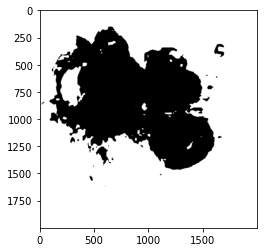

In [5]:
# 测试单张
import matplotlib.pyplot as plt

# 1. 初始化模型
model = FCN(num_classes=1)

def predict_single_image(model, image_path, transform_size=(512, 512)):
    # 加载和预处理图像
    image = Image.open(image_path).convert('RGB').resize(transform_size)
    image_tensor = paddle.to_tensor(np.array(image).astype('float32').transpose((2, 0, 1)) / 255.0)
    image_tensor = paddle.unsqueeze(image_tensor, 0)  # 添加batch维度

    # 使用模型进行预测
    model.eval()
    with paddle.no_grad():
        output = model(image_tensor)
        predicted_mask = (output > 0.5).astype('float32')

    # 将预测的掩码转换回图像格式
    mask_img = Image.fromarray((predicted_mask[0][0].numpy() * 255).astype(np.uint8)).resize((2000, 2000))
    
    return mask_img

# 加载模型参数
model_path = "FCN_models/FCN_epoch50.pdparams"
model_state_dict = paddle.load(model_path)
model.set_state_dict(model_state_dict)

# 预测单张图像
image_path = "V0017.jpg"
predicted_mask_img = predict_single_image(model, image_path)

# 展示预测的掩码
plt.imshow(predicted_mask_img, cmap='gray')
plt.show()

# 保存预测的掩码
predicted_mask_img.save("V0017.bmp")
